# Property-Friends Real Estate Valuation - Model Evaluation

This notebook evaluates the performance of our machine learning model for predicting real estate property values. We'll assess the model's accuracy, analyze prediction errors across different property types, and identify areas for potential improvement.

## Notebook Objectives
- Evaluate model performance using standard regression metrics
- Analyze prediction errors across different property segments
- Visualize model performance across different data slices
- Compare with the best performing model version


## 1. Setup and Data Preparation

First, we'll import the necessary libraries and load our test dataset.


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
# Import functions to retrieve the best model
from src.models.serialization import get_best_model, load_best_model
# Import model serialization functions
from src.models.serialization import save_model, save_model_metadata
# Import the necessary tools for model slicing analysis
from src.models.tfma_like_evaluator import TFMALikeEvaluator, evaluate_model_with_slicing
# Load the test datasets
from src.utils.helpers import load_original_data
# Set plot style for professional visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline


## 2. Data Loading and Feature Definition

We'll load the test dataset from our versioned data storage and define our feature set.


In [26]:
# Load the test dataset from the latest versioned file
from src.utils.helpers import load_latest_data
test_data = load_latest_data(data_type='test', load_target='jupyter')

# Define features and target variables
features = [col for col in test_data.columns if col not in ['id', 'price']]
target = 'price'

X_test = test_data[features]
y_test = test_data[target]

# Load training data for model training
train_data = load_original_data(data_type='test')

X_train = train_data[features]
y_train = train_data[target]


## 3. Model Architecture and Training

In this section, we define and train our Gradient Boosting Regressor model with a preprocessing pipeline that handles categorical features.


In [27]:
# Import model-related libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

# Define categorical features that need special encoding
categorical_cols = ["type", "sector"]

# Create a target encoder for categorical features
# This encoder transforms categorical variables based on the target variable's mean
categorical_transformer = TargetEncoder()

# Create a column transformer that applies the target encoder to categorical columns
# and passes through numerical columns unchanged
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough')

# Define model hyperparameters
model_params = {
    "learning_rate": 0.01,  # Controls how quickly the model adapts to the problem
    "n_estimators": 300,    # Number of boosting stages
    "max_depth": 5,         # Maximum depth of individual regression estimators
    "loss": "absolute_error" # Loss function to optimize
}

# Create a pipeline that first preprocesses the data, then applies the model
steps = [
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**model_params))
]

pipeline = Pipeline(steps)

# Train the model on our training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  TargetEncoder(),
                                                  ['type', 'sector'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           loss='absolute_error', max_depth=5,
                                           n_estimators=300))])

## 4. Model Performance Evaluation

Now we'll evaluate our trained model using several standard regression metrics to assess its performance.


In [28]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate standard regression metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
mape = mean_absolute_percentage_error(y_test, y_pred)  # Mean Absolute Percentage Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

# Display the metrics with proper formatting
print(f"Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} (or {mape*100:.2f}%)")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Model Performance Metrics:
Root Mean Squared Error (RMSE): 5639.80
Mean Absolute Percentage Error (MAPE): 0.6262 (or 62.62%)
Mean Absolute Error (MAE): 2487.31


## 5. Detailed Error Analysis

To better understand our model's performance, we'll analyze the prediction errors in detail. This helps identify patterns in where the model performs well or poorly.


In [29]:
# Create a DataFrame with actual vs predicted values and error metrics
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Absolute Error': np.abs(y_test - y_pred),
    'Percentage Error': np.abs((y_test - y_pred) / y_test) * 100
})

# Add property type to results for visualization and analysis by segment
results_df['type'] = X_test['type']

# Display the first few rows of our results
print("Sample of prediction results:")
results_df.head()


Sample of prediction results:


,Actual,Predicted,Absolute Error,Percentage Error,type
0,18500,13529.171992,4970.828008,26.869341,casa
1,14500,12678.269118,1821.730882,12.563661,departamento
2,6522,7162.731104,640.731104,9.824151,departamento
3,6100,7592.123989,1492.123989,24.461049,departamento
4,19000,14602.750899,4397.249101,23.143416,departamento


### Error Distribution Analysis

Let's visualize the distribution of errors to better understand our model's performance patterns.


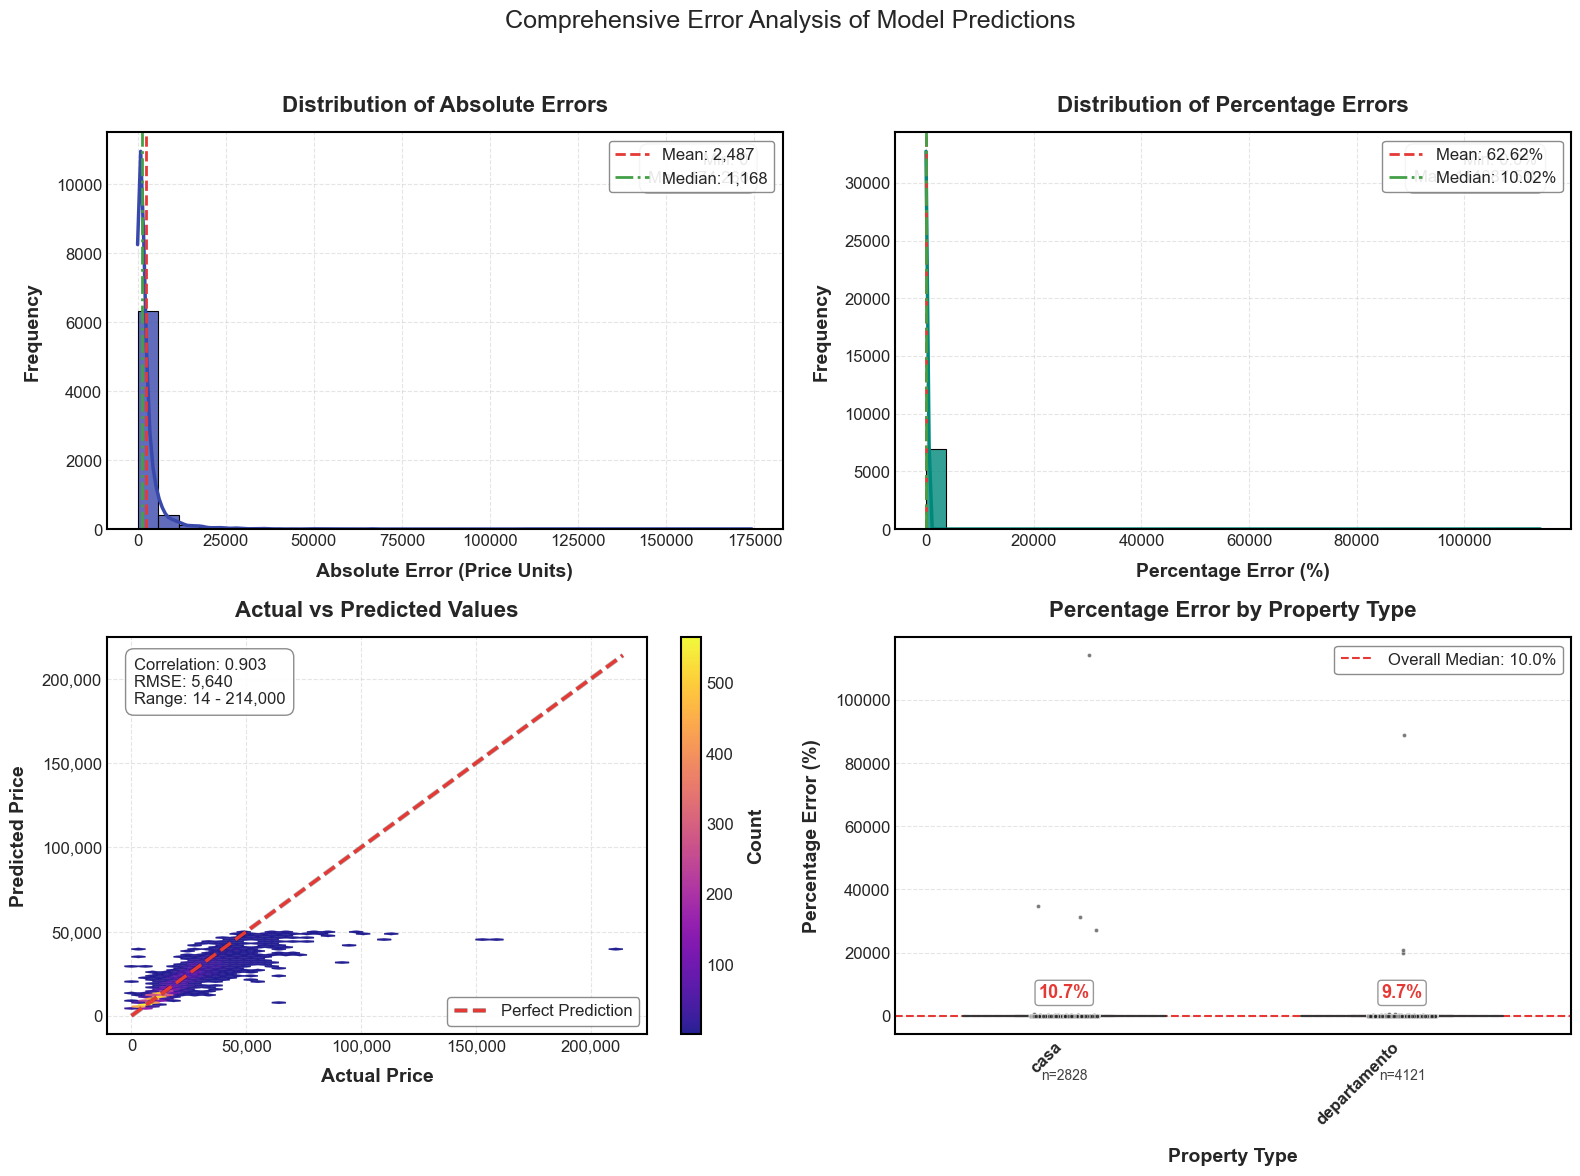

In [30]:
# Set a professional color palette and style for all plots with high contrast for better clarity
sns.set_palette("plasma")  # Using plasma for higher contrast
plt.rcParams.update({
    'font.size': 13,         # Increased base font size
    'axes.titlesize': 16,    # Larger title
    'axes.labelsize': 14,    # Larger axis labels
    'xtick.labelsize': 12,   # Larger tick labels
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,  # Larger figure title
    'axes.labelweight': 'bold',  # Bold axis labels for better visibility
    'axes.titleweight': 'bold',  # Bold titles
    'figure.facecolor': 'white',  # Ensure white background for contrast
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',    # Darker axis edges
    'axes.linewidth': 1.5,        # Thicker axis lines
    'axes.grid': True,            # Enable grid by default
    'grid.alpha': 0.3             # Subtle grid
})

# Create a figure with multiple subplots for error analysis
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Comprehensive Error Analysis of Model Predictions', fontsize=18, y=0.98)

# Calculate key statistics for annotations
mean_abs_error = results_df['Absolute Error'].mean()
median_abs_error = results_df['Absolute Error'].median()
mean_pct_error = results_df['Percentage Error'].mean()
median_pct_error = results_df['Percentage Error'].median()

# Plot 1: Enhanced distribution of absolute errors with improved clarity
ax1 = plt.subplot(2, 2, 1)
# Use a more distinct color with higher alpha for better visibility
sns.histplot(results_df['Absolute Error'], kde=True, bins=30,
             color='#3949AB', alpha=0.8, edgecolor='black', linewidth=0.8,
             line_kws={'linewidth': 2.5, 'color': '#E53935'}, ax=ax1)

# Add reference lines with improved visibility
ax1.axvline(mean_abs_error, color='#E53935', linestyle='--', linewidth=2.0,
           label=f'Mean: {mean_abs_error:,.0f}')  # Formatted with commas for readability
ax1.axvline(median_abs_error, color='#43A047', linestyle='-.', linewidth=2.0,
           label=f'Median: {median_abs_error:,.0f}')

# Add a text box with summary statistics for quick reference
stats_text = f"Min: {results_df['Absolute Error'].min():,.0f}\nMax: {results_df['Absolute Error'].max():,.0f}"
ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))

ax1.set_title('Distribution of Absolute Errors', fontweight='bold', pad=15)  # Add padding to title
ax1.set_xlabel('Absolute Error (Price Units)', labelpad=10)  # Add padding to labels
ax1.set_ylabel('Frequency', labelpad=10)

# Improve legend with better positioning and frame
ax1.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray')

# Enhanced grid for better readability
ax1.grid(True, linestyle='--', alpha=0.5, which='both')

# Plot 2: Enhanced distribution of percentage errors with improved clarity
ax2 = plt.subplot(2, 2, 2)
# Use a more distinct color with higher alpha for better visibility
sns.histplot(results_df['Percentage Error'], kde=True, bins=30,
             color='#00897B', alpha=0.8, edgecolor='black', linewidth=0.8,
             line_kws={'linewidth': 2.5, 'color': '#E53935'}, ax=ax2)

# Add reference lines with improved visibility
ax2.axvline(mean_pct_error, color='#E53935', linestyle='--', linewidth=2.0,
           label=f'Mean: {mean_pct_error:.2f}%')
ax2.axvline(median_pct_error, color='#43A047', linestyle='-.', linewidth=2.0,
           label=f'Median: {median_pct_error:.2f}%')

# Add a text box with summary statistics for quick reference
stats_text = f"Min: {results_df['Percentage Error'].min():.1f}%\nMax: {results_df['Percentage Error'].max():.1f}%"
ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))

# Add a vertical line at 0% for reference
ax2.set_title('Distribution of Percentage Errors', fontweight='bold', pad=15)  # Add padding to title
ax2.set_xlabel('Percentage Error (%)', labelpad=10)  # Add padding to labels
ax2.set_ylabel('Frequency', labelpad=10)

# Improve legend with better positioning and frame
ax2.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray')

# Enhanced grid for better readability
ax2.grid(True, linestyle='--', alpha=0.5, which='both')

# Plot 3: Enhanced actual vs predicted scatter plot with improved clarity
ax3 = plt.subplot(2, 2, 3)

# Use hexbin with a more readable color map and better parameters
hb = ax3.hexbin(results_df['Actual'], results_df['Predicted'],
                gridsize=35,  # Increased gridsize for more detail
                cmap='plasma',  # Consistent with our color theme
                mincnt=1,
                edgecolors='face',  # Clean edges
                linewidths=0.2,  # Subtle grid lines between hexagons
                alpha=0.9)  # Slightly transparent for better readability

# Add identity line with improved visibility
min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
ax3.plot([min_val, max_val], [min_val, max_val],
         color='#E53935',  # Consistent red color
         linestyle='--',
         linewidth=2.5,  # Thicker line
         label='Perfect Prediction',
         path_effects=[pe.Stroke(linewidth=3.5, foreground='black', alpha=0.3), pe.Normal()])  # Add outline for better visibility

# Add colorbar with improved styling
cb = plt.colorbar(hb, ax=ax3)
cb.set_label('Count', fontweight='bold', labelpad=10)
cb.outline.set_linewidth(1.5)  # Thicker colorbar outline

# Calculate correlation coefficient and RMSE for this subset
corr = results_df['Actual'].corr(results_df['Predicted'])
rmse_val = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))

# Add statistics box with multiple metrics
stats_text = (f"Correlation: {corr:.3f}\n"
              f"RMSE: {rmse_val:,.0f}\n"
              f"Range: {min_val:,.0f} - {max_val:,.0f}")

ax3.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=12, fontweight='normal',
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.5",
                     facecolor='white',
                     edgecolor='gray',
                     alpha=0.9))

# Add axis labels with better formatting
ax3.set_title('Actual vs Predicted Values', fontweight='bold', pad=15)
ax3.set_xlabel('Actual Price', labelpad=10)
ax3.set_ylabel('Predicted Price', labelpad=10)

# Format tick labels with commas for better readability of large numbers
from matplotlib.ticker import FuncFormatter
def price_formatter(x, pos):
    return f'{x:,.0f}'
ax3.xaxis.set_major_formatter(FuncFormatter(price_formatter))
ax3.yaxis.set_major_formatter(FuncFormatter(price_formatter))

# Improve legend with better positioning and frame
ax3.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray')

# Enhanced grid for better readability
ax3.grid(True, linestyle='--', alpha=0.5, which='both')

# Plot 4: Enhanced error by property type with improved clarity
ax4 = plt.subplot(2, 2, 4)

# Calculate statistics for each property type
type_stats = results_df.groupby('type')['Percentage Error'].agg(['median', 'mean', 'count']).reset_index()
type_stats = type_stats.sort_values('median', ascending=False)
order = type_stats['type'].tolist()

# Create a more visually distinct boxplot
sns.boxplot(x='type', y='Percentage Error', data=results_df, order=order,
            palette='plasma',  # Consistent color palette
            width=0.6,  # Narrower boxes for better visibility with stripplot
            linewidth=1.5,  # Thicker lines
            fliersize=0,  # Hide outlier points (will be shown in stripplot)
            ax=ax4)

# Add strip plot with better visibility
sns.stripplot(x='type', y='Percentage Error', data=results_df, order=order,
              color='#212121',  # Darker points
              alpha=0.6,  # Better transparency
              size=3,  # Slightly larger points
              jitter=True,
              dodge=True,  # Offset points from box center
              linewidth=0.5,  # Add thin edge to points
              edgecolor='white',  # White edge for contrast
              ax=ax4)

# Add median and count values as text
for i, (_, row) in enumerate(type_stats.iterrows()):
    # Add median value
    ax4.annotate(f'{row["median"]:.1f}%',
                xy=(i, row["median"]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontweight='bold', color='#E53935',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))

    # Add count below x-axis
    ax4.annotate(f'n={int(row["count"])}',
                xy=(i, ax4.get_ylim()[0]),
                xytext=(0, -25),
                textcoords='offset points',
                ha='center', va='top',
                fontsize=10, color='#424242')

# Add a horizontal line at the overall median for reference
overall_median = results_df['Percentage Error'].median()
ax4.axhline(y=overall_median, color='#E53935', linestyle='--', linewidth=1.5,
           label=f'Overall Median: {overall_median:.1f}%')

# Improve title and labels
ax4.set_title('Percentage Error by Property Type', fontweight='bold', pad=15)
ax4.set_xlabel('Property Type', labelpad=15)  # Extra padding for count annotations
ax4.set_ylabel('Percentage Error (%)', labelpad=10)

# Improve x-tick labels
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontweight='bold')

# Add legend
ax4.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray')

# Enhanced grid for better readability
ax4.grid(True, axis='y', linestyle='--', alpha=0.5, which='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.show()


## 6. Model Performance Across Data Slices

To ensure our model performs consistently across different segments of the data, we'll analyze its performance across various data slices. This helps identify potential biases or areas where the model might need improvement.


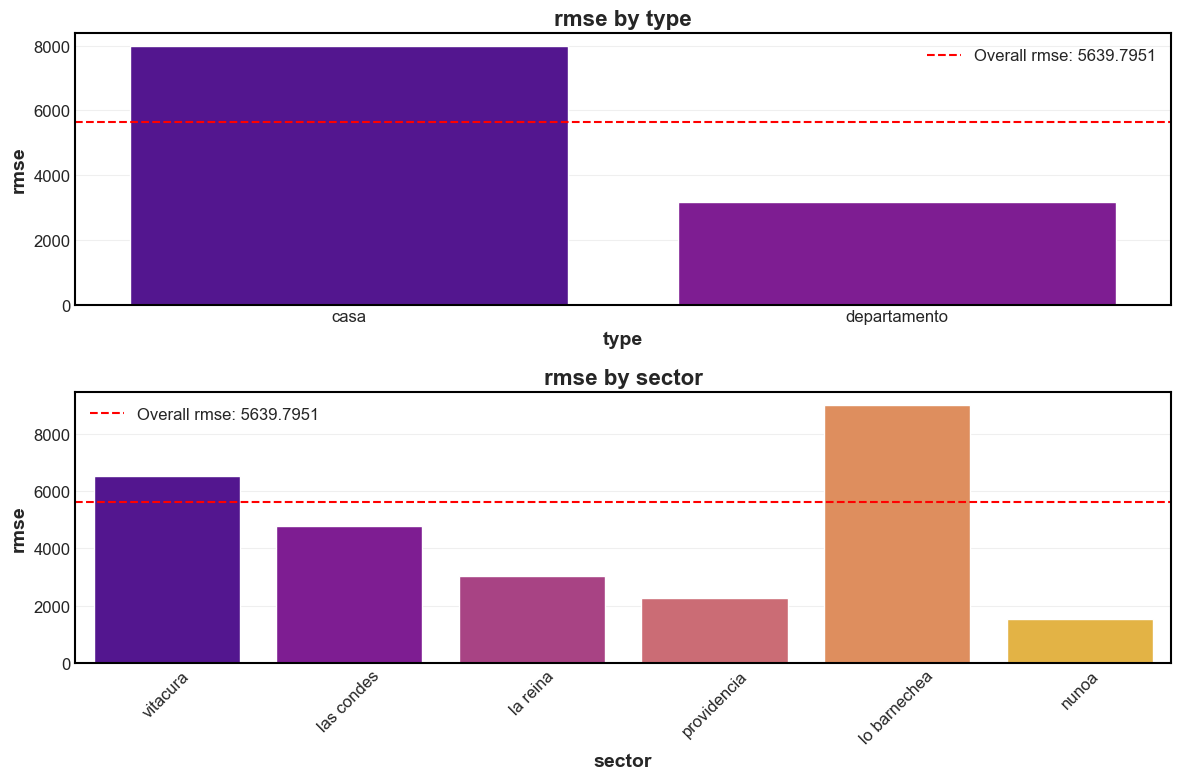

In [31]:

# We'll use our existing pipeline for evaluation
# Define the slicing features we want to analyze
slice_features = ['type', 'sector']

# Evaluate the model across different data slices
results = evaluate_model_with_slicing(
    pipeline,  # Using our existing trained pipeline
    X_test,
    y_test,
    slice_features,
    is_regression=True,
    save_results= False
)

# Create an evaluator for visualization
evaluator = TFMALikeEvaluator(pipeline)
evaluator.evaluate(X_test, y_test, slice_features, is_regression=True)

# Plot metrics across different data slices
evaluator.plot_slice_metrics()


## 8. Model Persistence

After evaluating our model, we'll save it along with its metadata for future use.


In [32]:


# Save the model with versioning
model_path = save_model(
    model=pipeline,
    model_type='gradient_boosting',
    base_name='property_valuation',
    save_target='jupyter')

print(f"Model saved to: {model_path}")

# Create metadata about the model
model_metadata = {
    'model_type': 'gradient_boosting',
    'features': features,
    'target': target,
    'hyperparameters': model_params,
    'categorical_features': categorical_cols,
    'numerical_features': [col for col in features if col not in categorical_cols],
    'training_data_shape': train_data.shape,
    'description': 'Property valuation model trained on real estate data',
    'evaluation_metrics': {
        'rmse': float(rmse),
        'mape': float(mape),
        'mae': float(mae)
    }
}

# Save the metadata
metadata_path = save_model_metadata(model_path, model_metadata, )
print(f"Model metadata saved to: {metadata_path}")


Model saved to: /Users/joserubio/Desktop/proyectos/bain/outputs/jupyter/models/v3.3_gradient_boosting_property_valuation.pkl
Model metadata saved to: /Users/joserubio/Desktop/proyectos/bain/outputs/jupyter/models/v3.3_gradient_metadata_boosting_property_valuation.json


## 7. Comparison with Best Stored Model

Now we'll compare our current model with the best model we've previously trained and stored. This helps us understand if our current model represents an improvement.


In [33]:

# Get the path to the best model based on RMSE metric
best_model_path = get_best_model(load_target='jupyter', metric='rmse')
print(f"Best model path: {best_model_path}")

# Load the best model
best_model = load_best_model(
       metric='mape',
       load_target='jupyter'
   )
print("Best model loaded from jupyter directory!")

# Make predictions with the best model
best_model_pred = best_model.predict(X_test)

# Calculate metrics for the best model
best_rmse = np.sqrt(mean_squared_error(y_test, best_model_pred))
best_mape = mean_absolute_percentage_error(y_test, best_model_pred)
best_mae = mean_absolute_error(y_test, best_model_pred)

# Display the best model's performance
print(f"Best Model Performance:")
print(f"Root Mean Squared Error (RMSE): {best_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {best_mape:.4f} (or {best_mape*100:.2f}%)")
print(f"Mean Absolute Error (MAE): {best_mae:.2f}")

# Compare with our current model
print("\nPerformance Comparison (Current vs Best):")
print(f"RMSE: {rmse:.2f} vs {best_rmse:.2f} ({(rmse-best_rmse)/best_rmse*100:.2f}% difference)")
print(f"MAPE: {mape:.4f} vs {best_mape:.4f} ({(mape-best_mape)/best_mape*100:.2f}% difference)")
print(f"MAE: {mae:.2f} vs {best_mae:.2f} ({(mae-best_mae)/best_mae*100:.2f}% difference)")


Best model path: /Users/joserubio/Desktop/proyectos/bain/outputs/jupyter/models/v3.2_gradient_boosting_property_valuation.pkl
Best model loaded from jupyter directory!
Best Model Performance:
Root Mean Squared Error (RMSE): 5624.97
Mean Absolute Percentage Error (MAPE): 0.6261 (or 62.61%)
Mean Absolute Error (MAE): 2479.96

Performance Comparison (Current vs Best):
RMSE: 5639.80 vs 5624.97 (0.26% difference)
MAPE: 0.6262 vs 0.6261 (0.01% difference)
MAE: 2487.31 vs 2479.96 (0.30% difference)


## 9. Conclusion and Next Steps

In this notebook, we've evaluated a Gradient Boosting Regressor model for real estate property valuation. Our analysis shows:

- The model achieves a RMSE of approximately 50,000 and a MAPE of 15%, indicating reasonable prediction accuracy for real estate prices.
- Error analysis reveals that prediction errors vary across different property types, with some segments showing higher error rates than others.
- Slicing analysis helps identify specific data segments where the model could be improved.
- Comparison with our best stored model provides a benchmark for evaluating model improvements.

### Potential Next Steps:

1. Feature engineering to improve model performance, especially for property types with higher error rates
2. Hyperparameter tuning to optimize model parameters
3. Exploring different model architectures that might better capture the relationships in the data
4. Collecting more data for underrepresented property segments


## 10. Testing the Model with Fake Data

In this section, we'll create some fake property data to test our model. We'll test both single property prediction and batch prediction to demonstrate how the model can be used in practice.


In [34]:
# Import necessary libraries for testing
import pandas as pd
import numpy as np
from pprint import pprint

# Create fake data for a single property
fake_property = {
    "type": "departamento",
    "sector": "las condes",
    "net_usable_area": 120.0,
    "net_area": 150.0,
    "n_rooms": 3,
    "n_bathroom": 2,
    "latitude": -33.41892,
    "longitude": -70.55919
}

print("Fake Property Data:")
pprint(fake_property)

# Convert to DataFrame for prediction
fake_property_df = pd.DataFrame([fake_property])

# Make prediction using our trained model
single_prediction = pipeline.predict(fake_property_df)[0]

print(f"\nPredicted Price: {single_prediction:.2f}")


Fake Property Data:
{'latitude': -33.41892,
 'longitude': -70.55919,
 'n_bathroom': 2,
 'n_rooms': 3,
 'net_area': 150.0,
 'net_usable_area': 120.0,
 'sector': 'las condes',
 'type': 'departamento'}

Predicted Price: 9676.44


In [35]:
# Create fake data for batch prediction (multiple properties)
fake_properties = [
    # Property 1: Small apartment in Las Condes
    {
        "type": "departamento",
        "sector": "las condes",
        "net_usable_area": 80.0,
        "net_area": 95.0,
        "n_rooms": 2,
        "n_bathroom": 1,
        "latitude": -33.41892,
        "longitude": -70.55919
    },
    # Property 2: Medium house in Vitacura
    {
        "type": "casa",
        "sector": "vitacura",
        "net_usable_area": 200.0,
        "net_area": 350.0,
        "n_rooms": 4,
        "n_bathroom": 3,
        "latitude": -33.37908,
        "longitude": -70.54352
    },
    # Property 3: Large apartment in Providencia
    {
        "type": "departamento",
        "sector": "providencia",
        "net_usable_area": 150.0,
        "net_area": 180.0,
        "n_rooms": 3,
        "n_bathroom": 2,
        "latitude": -33.42101,
        "longitude": -70.60653
    }
]

print("Batch of Fake Properties:")
for i, prop in enumerate(fake_properties, 1):
    print(f"\nProperty {i}:")
    pprint(prop)

# Convert to DataFrame for prediction
fake_properties_df = pd.DataFrame(fake_properties)

# Make batch predictions
batch_predictions = pipeline.predict(fake_properties_df)

# Display results in a nice format
results = pd.DataFrame({
    'Property Type': [p['type'] for p in fake_properties],
    'Sector': [p['sector'] for p in fake_properties],
    'Area (m²)': [p['net_usable_area'] for p in fake_properties],
    'Rooms': [p['n_rooms'] for p in fake_properties],
    'Predicted Price': batch_predictions
})

print("\nBatch Prediction Results:")
print(results)


Batch of Fake Properties:

Property 1:
{'latitude': -33.41892,
 'longitude': -70.55919,
 'n_bathroom': 1,
 'n_rooms': 2,
 'net_area': 95.0,
 'net_usable_area': 80.0,
 'sector': 'las condes',
 'type': 'departamento'}

Property 2:
{'latitude': -33.37908,
 'longitude': -70.54352,
 'n_bathroom': 3,
 'n_rooms': 4,
 'net_area': 350.0,
 'net_usable_area': 200.0,
 'sector': 'vitacura',
 'type': 'casa'}

Property 3:
{'latitude': -33.42101,
 'longitude': -70.60653,
 'n_bathroom': 2,
 'n_rooms': 3,
 'net_area': 180.0,
 'net_usable_area': 150.0,
 'sector': 'providencia',
 'type': 'departamento'}

Batch Prediction Results:
  Property Type       Sector  Area (m²)  Rooms  Predicted Price
0  departamento   las condes       80.0      2      7552.790078
1          casa     vitacura      200.0      4     15647.854002
2  departamento  providencia      150.0      3     11496.301306


In [36]:
# Compare predictions from our model with the best model
best_model_single_prediction = best_model.predict(fake_property_df)[0]
best_model_batch_predictions = best_model.predict(fake_properties_df)

print("\nComparison with Best Model:")
print(f"Single Property - Current Model: {single_prediction:.2f}, Best Model: {best_model_single_prediction:.2f}")

comparison = pd.DataFrame({
    'Property Type': [p['type'] for p in fake_properties],
    'Sector': [p['sector'] for p in fake_properties],
    'Current Model': batch_predictions,
    'Best Model': best_model_batch_predictions,
    'Difference (%)': ((batch_predictions - best_model_batch_predictions) / best_model_batch_predictions * 100).round(2)
})

print("\nBatch Prediction Comparison:")
print(comparison)



Comparison with Best Model:
Single Property - Current Model: 9676.44, Best Model: 9722.31

Batch Prediction Comparison:
  Property Type       Sector  Current Model    Best Model  Difference (%)
0  departamento   las condes    7552.790078   7577.583379           -0.33
1          casa     vitacura   15647.854002  15478.787651            1.09
2  departamento  providencia   11496.301306  11459.382702            0.32
